# Poisson likelihood and Gamma prior

This is a simple model where our discrete data, $y$, is modelled as a Poisson RV with Gamma prior, which is a conjugate prior model.

$L(x) = p(y | x) = \mathcal{P}[y \mid x]$

and

$p(x) = \Gamma[x \mid k, \theta]$.

The analytic evidence for this model is,

$Z = p(y) = \int_\mathcal{X} L(x) p(x) \,\mathrm{d} x =  \mathcal{P}[y \mid 1] \frac{\Gamma[1 \mid k, \theta]}{\Gamma[1 \mid k', \theta']}$

The posterior is also a Gamma distribution,

$p(x \mid y) = \Gamma[x \mid k', \theta']$

where

$k' = k + \sum_i y_i$

and

$\theta' = \frac{\theta}{(\theta \sum_i y_i + 1)}$

In [1]:

import numpy as np
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import resample

tfpd = tfp.distributions

/home/albert/git/jaxns/jaxns/internals/mixed_precision.py:15: UserWarning: JAX x64 is not enabled. Setting it now. Check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now. Check for errors.")
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [2]:
# Generate data
np.random.seed(42)

num_samples = 10

true_k = 0.5
true_theta = 1.
_gamma = np.random.gamma(true_k, true_theta, size=num_samples)
print(f"Taking {num_samples} samples from a Poisson distribution as data.")
data = jnp.asarray(np.random.poisson(_gamma, size=num_samples))

Taking 10 samples from a Poisson distribution as data.


In [3]:

from jaxns.internals.mixed_precision import mp_policy
from jaxns import Prior, Model

# Build model
prior_k = 100.

# Note if prior_theta is chosen too large 32-bit will be insufficient
prior_theta = 0.1


def prior_model():
    lamda = yield Prior(
        tfpd.Gamma(concentration=jnp.asarray(prior_k, mp_policy.measure_dtype),
                   rate=1. / jnp.asarray(prior_theta, mp_policy.measure_dtype)),
        name='lamda')
    return lamda


def log_likelihood(lamda):
    """
    Poisson likelihood.
    """
    _log_prob = jnp.sum(tfpd.Poisson(rate=lamda).log_prob(data))
    return _log_prob


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


In [4]:
# Evidence and posterior are analytic
def log_gamma_prob(lamda, k, theta):
    return tfpd.Gamma(concentration=k, rate=1. / theta).log_prob(lamda)
    # return (k-1) * jnp.log(gamma)  - gamma / theta - gammaln(k) - k * jnp.log(theta)


true_post_k = prior_k + jnp.sum(data)
true_post_theta = prior_theta / (num_samples * prior_theta + 1.)

true_post_mean_gamma = true_post_theta * true_post_k

true_logZ = log_likelihood(1.) + log_gamma_prob(1., prior_k, prior_theta) - log_gamma_prob(1., true_post_k,
                                                                                           true_post_theta)
print(f"True Evidence = {true_logZ}")
print(f"True posterior concentration (k) = {true_post_k}")
print(f"True posterior rate (1/theta) = {1. / true_post_theta}")
print(f"True posterior lamda = {true_post_mean_gamma}")


True Evidence = -69.31472389012055
True posterior concentration (k) = 100.0
True posterior rate (1/theta) = 20.0
True posterior lamda = 5.0


In [5]:
from jaxns import NestedSampler

# Run the nested sampling
ns = NestedSampler(model=model)
print(ns)

NestedSampler(model=<jaxns.framework.model.Model object at 0x7f9336c268d0>, max_samples=10000, num_live_points=30, s=5, k=0, c=30, num_parallel_workers=None, devices=None, difficult_model=False, parameter_estimation=False, init_efficiency_threshold=0.1, verbose=False)


sender_node_idx: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  15   0   0
   0  15   0   0  15  15   0  15   0   0  15  15   0  15  30  15  30  30
   0   0  30  30  30   0   0  30  30  45   0  45  45  15  45  45  30  45
  15  15  45  45  15  45  45  60  60  45  45  60  60  15  60  60  60  30
  60  30   0  75  60  75  75  45  45  30  75  60  30  75  75  75  75  75
  90  60  15  90  30  75  90  60  75  75  90  60  90  90  90  90  90  60
  90 105  75 105  45 105 105  90  90  75 105 105 105 120 120  90 120 105
 120 105 120 120  30 120 105 105 105 135 120 120 135 120 135 105 135 135
 135 135 135 135 135 120 120 150  90 150 150 150 150 135 135 135 120 150
 150 150 150 165 150 165  75 165 150 165 165 165 150 105 135 150  60 165
 120 180 165 180 165 180 135 180 180 180 165 165 150 180  90 180 165 195
 195 195 195 105 195 195 150 195 195 180 180 165 210 210 210 210 210 180
 210 195 180 120 180 180 195 210 210 225 195 210 195 225 210 180 210 225
 225 225 210 225 225 165 240 210 1

/home/albert/git/jaxns/jaxns/plotting.py:48: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")
/home/albert/git/jaxns/jaxns/plotting.py:52: RuntimeWarning: divide by zero encountered in divide
  1. / num_likelihood_evaluations_per_sample


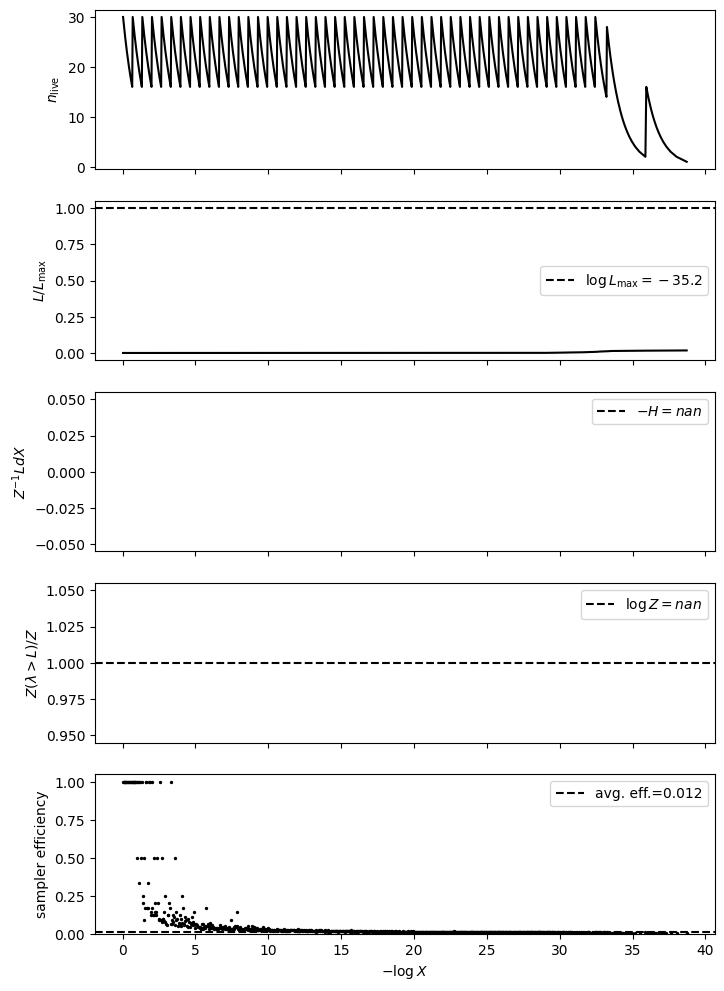

In [6]:


term_reason, state = ns(random.PRNGKey(3452345))
results = ns.to_results(termination_reason=term_reason, state=state)
ns.plot_diagnostics(results)

In [13]:
state.num_samples

Array(990, dtype=int64)

In [7]:
# Comparing samples to true posterior

samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=int(results.ESS))

plt.hist(samples['lamda'], bins='auto', ec='blue', alpha=0.5, density=True, fc='none')

_gamma = np.random.gamma(true_post_k, true_post_theta, size=100000)

plt.hist(_gamma, bins='auto', ec='orange', alpha=0.5, density=True, fc='none')
plt.show()

ValueError: cannot convert float NaN to integer